##Данные

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
!nvidia-smi

Fri Jul  3 10:48:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!unzip -q /content/gdrive/My\ Drive/detection_train_zip.zip -d train
!unzip -q /content/gdrive/My\ Drive/detection_test_zip.zip -d test

In [ ]:
!ls test

test


Необходимые импорты

In [3]:
import pickle
import numpy as np
from skimage import io
import torch
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib import colors, pyplot as plt
%matplotlib inline
import xml.etree.ElementTree as ET
from glob import glob
import warnings
import shutil
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import cv2
import os
import pandas as pd
import random
import torch
import torchvision
from glob import glob
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np
from copy import deepcopy
%matplotlib inline

##Решение задачи классификации

Прежде чем решать задачу детекции, для более подробного ознакомления с данными можно решить задачу классификации.

Создадим три датасета - тренировка, валидация, тест

In [ ]:
# разные режимы датасета 
DATA_MODES =['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class ClassificationDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode


        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.stem.split('_')[0] for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        #Аугментации
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.RandomRotation(25),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) #Для трейновой выборки всякие преобразования #inner

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) #Для тестовой - только нормализация #inner

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'test':
          return transform_test(x) #inner
        else:
          if self.mode == 'train':
            x= transform_train(x)
          else:
            x=transform_test(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y #inner
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

Напишем функцию для визуализации тензоров

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train')
TEST_DIR = Path('test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, random_state=42, shuffle=True)

In [ ]:
val_dataset = ClassificationDataset(val_files, mode='val')

In [ ]:
tr_dataset = ClassificationDataset(train_files, mode='train')

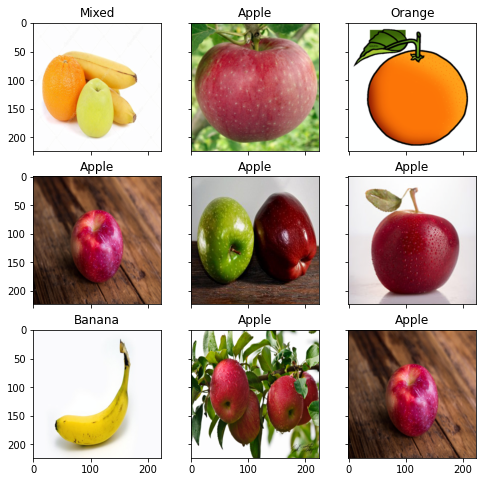

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,50))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
import torchvision.models as models
# Создаём сеть
model = models.resnet152(pretrained=True)
model = model.cuda(device='cuda')

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [ ]:
model.fc = nn.Linear(in_features=2048, out_features=4, bias=True).cuda()

In [ ]:
def train(train_files, model, batch_size, epoch):
  train_loader = DataLoader(tr_dataset, batch_size=5, shuffle = True, num_workers=4)
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.0002)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3)
  criterion = nn.CrossEntropyLoss()
  model.train()
  for i in range(epoch):
    running_loss = 0.0
    for k in enumerate(train_loader,0):
      optimizer.zero_grad()
      res = model(k[1][0].cuda())
      preds = torch.argmax(res, 1)
      loss = criterion(res, k[1][1].cuda())
      loss.backward()
      optimizer.step()
    scheduler.step()
    print(loss)


In [ ]:
train(tr_dataset, model, 10, 100)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1929, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.2251, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0593, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(3.4328, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.4387, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0868, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.2465, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0849, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.5621, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.8383, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.3234, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0483, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.4983, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(1.0451, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1475, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.6039, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0449, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.9369, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1691, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.5641, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.4505, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0312, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0186, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0884, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0468, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0281, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1360, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.2215, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.3045, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.8529, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0400, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.8704, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1852, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0322, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0321, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.5153, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.4884, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.3076, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0677, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1036, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.3416, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1775, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.3077, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0586, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1326, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.4091, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0898, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.4233, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.6227, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.3890, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.2690, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.3841, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0265, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.3240, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0336, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.2111, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1616, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0285, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0675, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1933, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1453, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1160, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.2300, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1913, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.8457, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0171, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1302, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0637, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.3067, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.2255, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1461, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0423, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.2809, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1130, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1742, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.2591, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.3303, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0590, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1861, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.8390, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0590, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0524, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1441, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1500, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.5024, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.5080, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.4300, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.3359, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1287, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.1683, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0926, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(1.3611, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.2850, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.5197, device='cuda:0', grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor(0.0801, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

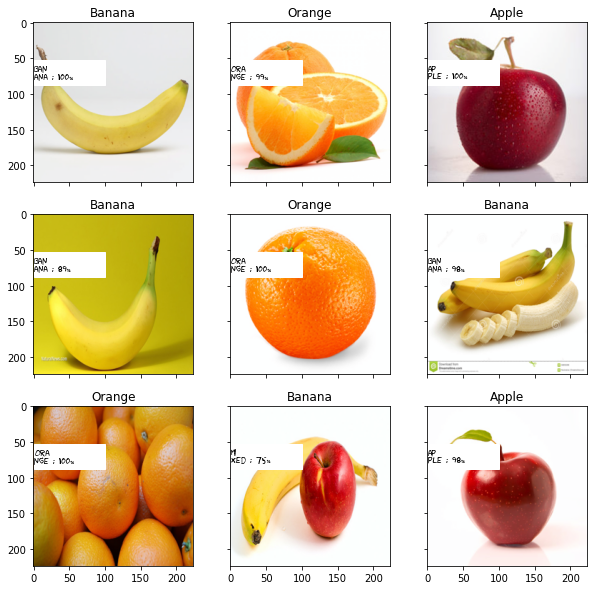

In [ ]:


fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,50))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Таким образом, задача классификации решается достаточно просто. Теперь приступим к задаче детекции.

##Детекция

###Пункт 1 и 2. Общий этап работы

Выбран фреймворк PyTorch

Запуск детектора на случайных изображениях

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
!wget https://image.shutterstock.com/image-photo/group-people-260nw-602783837.jpg test.jpg
!mv group-people-260nw-602783837.jpg test.jpg
!ls

--2020-07-01 13:38:49--  https://image.shutterstock.com/image-photo/group-people-260nw-602783837.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 23.210.254.60
Connecting to image.shutterstock.com (image.shutterstock.com)|23.210.254.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78331 (76K) [image/jpeg]
Saving to: ‘group-people-260nw-602783837.jpg’

group-people-260nw- 100%[===================>]  76.50K  --.-KB/s    in 0.01s   

2020-07-01 13:38:49 (5.21 MB/s) - ‘group-people-260nw-602783837.jpg’ saved [78331/78331]

--2020-07-01 13:38:49--  http://test.jpg/
Resolving test.jpg (test.jpg)... failed: Name or service not known.
wget: unable to resolve host address ‘test.jpg’
FINISHED --2020-07-01 13:38:49--
Total wall clock time: 0.1s
Downloaded: 1 files, 76K in 0.01s (5.21 MB/s)
sample_data  test.jpg


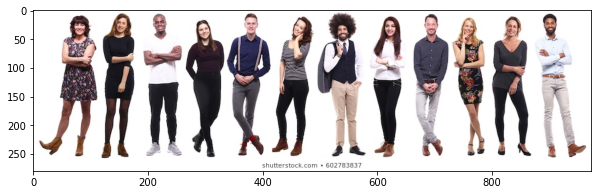

In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img_path = './test.jpg'
img = cv2.imread(img_path)[:,:,::-1]
fig = plt.figure(figsize=(10,5))
plt.imshow(img);

In [ ]:
model = model.eval()
img_numpy = cv2.imread(img_path)[:,:,::-1]
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1)
print(img.shape)

predictions = model(img[None,...])
predictions

torch.Size([3, 280, 974])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


[{'boxes': tensor([[  0.,   0., 974., 280.]], grad_fn=<StackBackward>),
  'labels': tensor([1]),
  'scores': tensor([1.], grad_fn=<IndexBackward>)}]

In [ ]:
def plot_preds(numpy_img, preds):
  boxes = preds['boxes'].detach().numpy()
  for box in boxes:
    numpy_img = cv2.rectangle(
        numpy_img, 
        (box[0],box[1]),
        (box[2],box[3]), 
        255,
        3
    )
  return numpy_img.get()

torch.Size([3, 280, 974])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(280, 974, 3)


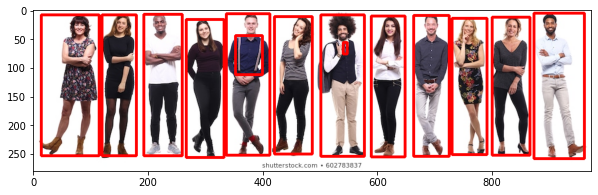

In [ ]:
model = model.eval()
img_numpy = cv2.imread(img_path)[:,:,::-1]
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1)
img = img / 255.
print(img.shape)

predictions = model(img[None,...])

CONF_THRESH = 0.5
boxes = predictions[0]['boxes'][predictions[0]['scores'] > CONF_THRESH]
boxes_dict = {}
boxes_dict['boxes'] = boxes

img_with_boxes = plot_preds(img_numpy, boxes_dict)
print(img_with_boxes.shape)
fig = plt.figure(figsize=(10,5))
plt.imshow(img_with_boxes.astype('uint'));

torch.Size([3, 1024, 1024])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(1024, 1024, 3)


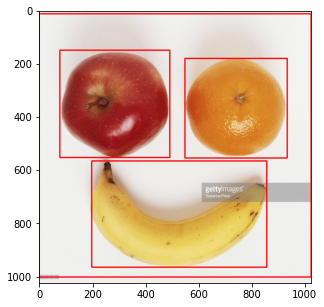

In [ ]:
model = model.eval()
img_numpy = cv2.imread('/content/train/train/mixed_5.jpg')[:,:,::-1]
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1)
img = img / 255.
print(img.shape)

predictions = model(img[None,...])

CONF_THRESH = 0.5
boxes = predictions[0]['boxes'][predictions[0]['scores'] > CONF_THRESH]
boxes_dict = {}
boxes_dict['boxes'] = boxes

img_with_boxes = plot_preds(img_numpy, boxes_dict)
print(img_with_boxes.shape)
fig = plt.figure(figsize=(10,5))
plt.imshow(img_with_boxes.astype('uint'));

In [ ]:
model = model.eval()
img_numpy = cv2.imread(img_path)[:,:,::-1]
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1)
img = img / 255.
print(img.shape)

predictions = model(img[None,...])

CONF_THRESH = 0.5
boxes = predictions[0]['boxes'][predictions[0]['scores'] > CONF_THRESH]
boxes_dict = {}
boxes_dict['boxes'] = boxes

img_with_boxes = plot_preds(img_numpy, boxes_dict)
print(img_with_boxes.shape)
fig = plt.figure(figsize=(10,5))
plt.imshow(img_with_boxes.astype('uint'));

###Второй сценарий

Датасет состоит из картинок в формате .jpg и разметки в формате .xml. В первую очередь, необходимо создать функцию, которая будет принимать на вход датасет и из него "вытаскивать" координаты объекта. Функция ниже конвертирует xml файлы в DataFrame и/или csv-файл.Каждый xml-файл относится к определенной картинке и содержит название, размер, метки и координаты box-ов объекта. Выходной объект функции содержит ту же информацию.

In [5]:
def xml_to_csv(xml_folder, output_file=None):
    xml_list = []
    #Итерируемся по каждому xml файлу
    for xml_file in glob(xml_folder + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        filename = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        for member in root.findall('object'):
            box = member.find('bndbox')
            label = member.find('name').text

            # Добавляем название картинки, размер, метку координаты в csv файл
            row = (filename, width, height, label, int(box[0].text),
                   int(box[1].text), int(box[2].text), int(box[3].text))
            xml_list.append(row)

    # Сохраняем CSV 
    column_names = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_names)

    if output_file is not None:
        xml_df.to_csv(output_file, index=None)

    return xml_df

Пример выхода функции

In [6]:
xml_to_csv('/content/train/train')

,filename,width,height,class,xmin,ymin,xmax,ymax
0,orange_54.jpg,500,500,orange,4,37,340,400
1,apple_61.jpg,500,500,apple,234,132,416,343
2,apple_11.jpg,652,436,apple,213,33,459,258
3,apple_11.jpg,652,436,apple,1,30,188,280
4,apple_11.jpg,652,436,apple,116,5,337,220
...,...,...,...,...,...,...,...,...
460,orange_34.jpg,1600,1200,orange,990,370,1578,974
461,mixed_15.jpg,1200,798,orange,485,43,908,469
462,mixed_15.jpg,1200,798,apple,173,127,653,611
463,mixed_15.jpg,1200,798,banana,283,215,1172,764


In [7]:
#Просто функция для проверки переменной - список или кортеж
def _is_iterable(variable):
    return isinstance(variable, list) or isinstance(variable, tuple)

Функция ниже фильтрует самые "уверенные" предсказания для каждого класса

In [8]:
def filter_top_predictions(prediction):
    filtered_labels = []
    filtered_boxes = []
    filtered_scores = []
    for j in range(len(prediction[-1])):
      if prediction[-1][j]>0.7:
        filtered_labels.append(prediction[0][j])
        filtered_boxes.append(prediction[1][j])
        filtered_scores.append(prediction[2][j])

    if len(filtered_labels) == 0:
        return filtered_labels, torch.empty(0, 4), torch.tensor(filtered_scores)
    return filtered_labels, torch.stack(filtered_boxes), torch.tensor(filtered_scores)

Функция для базовых преобразований - только перевод картинки в тензор и нормализация

In [9]:
def default_transforms():
    return transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

Функция для перевода картинки в формат numpy и переводит в формат RGB

In [10]:
def read_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

###Пункт 3 и 4. Выбор датасета и предобработка данных

Был выбран датасет фруктов

####Dataloader и Dataset

DataLoader принимает на вход датасет и создает батчи

In [11]:
class DataLoader(torch.utils.data.DataLoader):

    def __init__(self, dataset, **kwargs):
        super().__init__(dataset, collate_fn=DataLoader.collate_data, **kwargs)

    @staticmethod
    def collate_data(batch):
        images, targets = zip(*batch)
        return list(images), list(targets)


Dataset принимает на вход путь к данным (или два пути - к картинкам и разметке отдельно) и создает индексированный датасет. Может применять трансформации к данным

In [12]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, label_data, image_folder=None, transform=None):

        
        if os.path.isfile(label_data):
            self._csv = pd.read_csv(label_data)
        else:
            self._csv = xml_to_csv(label_data)

        
        if image_folder is None:
            self._root_dir = label_data
        else:
            self._root_dir = image_folder

        if transform is None:
            self.transform = default_transforms()
        else:
            self.transform = transform

  
    def __len__(self):
        return len(self._csv)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()


        img_name = os.path.join(self._root_dir, self._csv.iloc[idx, 0])
        image = read_image(img_name)


        l = self._csv['filename'].unique()
        z=[]
        q=0
        for i in l:
          for m in self._csv['filename']:
            if i==m:
              z.append(q)
          q+=1
        self._csv['h'] = z
        a = self._csv.iloc[idx,-1]
        mask = self._csv['h']==a

        box = self._csv[mask].iloc[:, 4:8]

        box = torch.tensor(np.array(box))


        label = list(self._csv[mask].iloc[:, 3])

        targets = {'boxes': box, 'labels': label}

        #Применяем трансформации
        if self.transform:
            width = self._csv.loc[idx, 'width']
            height = self._csv.loc[idx, 'height']

            updated_transforms = []
            scale_factor = 1.0
            random_flip = 0.0
            for t in self.transform.transforms:
                # Добавляем трансформацию в список
                updated_transforms.append(t)

                # Если есть уменьшающие трансформации, масштабируем боксы тоже
                if isinstance(t, transforms.Resize):
                    original_size = min(height, width)
                    scale_factor = original_size / t.size

                elif isinstance(t, transforms.RandomHorizontalFlip):
                    random_flip = t.p

            # Применяем трансформации вручную
            for t in updated_transforms:
                if isinstance(t, transforms.RandomHorizontalFlip):
                    if random.random() < random_flip:
                        image = transforms.RandomHorizontalFlip(0.5)(image)
                        # Flip box's x-coordinates
                        for i in range(len(box)):
                          box[i, 0] = width - box[i, 0]
                          box[i, 2] = width - box[i, 2]
                          box[i, 0], box[i, 2] = box[i, (2, 0)]
                else:
                    image = t(image)

            #Масштабируем, если необходимо
            targets['boxes'] = (box / scale_factor).long()

        return image, targets

####Создание директории с валидационной выборкой

Поскольку в этом случае мы не создавали mode = 'train' и mode = 'val', то для того, чтобы применятьь трансформации отдельно, нам необходимо создать директорию с валидационной выборкой и подавать её в Dataset без трансформаций, а директорию с тренировочной выборкой подавать с трансформациями. Все классы должны присутствовать как в валидационной, так и в тренировоной выборках.

In [ ]:
apple = []
orange = []
banana = []
mix = []
for i in sorted(glob('/content/train/train'+'/*')):
  if 'apple' in i:
    apple.append(i)
  elif 'orange' in i:
    orange.append(i)
  elif 'banana' in i:
    banana.append(i)
  else:
    mix.append(i)


In [ ]:
apple_train = apple[:100]
apple_val = apple[100:]
orange_train = orange[:100]
orange_val = orange[100:]
banana_train = banana[:100]
banana_val = banana[100:]
mix_train = mix[:30]
mix_val = mix[30:]

In [ ]:
train = apple_train+orange_train+banana_train+mix_train
val = apple_val+orange_val+banana_val+mix_val

In [ ]:
for t in train:
  if not os.path.exists(os.path.join('/content/gdrive/My Drive', 'train')):
    os.makedirs(os.path.join('/content/gdrive/My Drive', 'train'))
  shutil.move(t, os.path.join('/content/gdrive/My Drive', 'train'))

for v in val:
  if not os.path.exists(os.path.join('/content/gdrive/My Drive', 'val')):
    os.makedirs(os.path.join('/content/gdrive/My Drive', 'val'))
  shutil.move(v, os.path.join('/content/gdrive/My Drive', 'val'))


Функция для передачи объектов на видеокарту

In [22]:
def _to_device(images, targets):
  images = [image.to('cuda') for image in images]
  n=[]
  for t in targets:
    d = {}
    for k, v in  t.items():
      if k=='boxes':
        d[k] = v.float().to('cuda')
      elif k=='labels':
        v1=[]
        for i in v:
          v1.append(i)
        d[k] = torch.tensor(v1, dtype= torch.int64).to('cuda')
    n.append(d)
  targets = n

  return images, targets


Функция для перевода текстовых меток в числовые

In [13]:
def _convert_to_int_labels(targets):
  for target in targets:
    k=[]
    for i in target['labels']:
      i = torch.tensor(int_mapping[i]).view(1)
      k.append(i)
    target['labels'] = k

Функция для изображения картинки с метками и боксами.

In [14]:
def show_labeled_image(image, boxes, labels=None):
    fig, ax = plt.subplots(1)
    imshow(image)

    
    if boxes.ndim == 1:
        boxes = boxes.view(1, 4)

    if labels is not None and not _is_iterable(labels):
        labels = [labels]

    # Рисуем каждый бокс
    for i in range(boxes.shape[0]):
        box = boxes[i]
        width, height = (box[2] - box[0]).item(), (box[3] - box[1]).item()
        initial_pos = (box[0].item(), box[1].item())
        rect = patches.Rectangle(initial_pos,  width, height, linewidth=1,
                                 edgecolor='r', facecolor='none')
        if labels:
            ax.text(box[0] + 5, box[1] - 5, '{}'.format(labels[i]), color='red')

        ax.add_patch(rect)

    plt.show()

###Пункт 5. Тренировка

В датасете 3 класса - яблоки, апельсины и бананы. В качестве модели возьмем torchvision.models.detection.fasterrcnn_resnet50_fpn. Перенесем модель на видеокарту.

In [15]:
classes = ['apple', 'orange', 'banana']
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(classes) + 1)
model.to('cuda')
classes = ['__background__'] + classes
int_mapping = {label: index for index, label in enumerate(classes)}

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Функция для тренировки. Принимает на вход тренировочную и валидационную выборки, количество эпох, скорость обучения и параметры планировщика. На каждой эпохе сохнаняет модель и выводит лосс на трейне и валидации

In [16]:
def train(dataset, val_dataset=None, epochs=10):
  if not isinstance(dataset, DataLoader):
    dataset = DataLoader(dataset, shuffle=True)
  if val_dataset is not None and not isinstance(val_dataset, DataLoader):
    val_dataset = DataLoader(val_dataset)
  losses = []
  parameters = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(parameters, lr=0.001,momentum=0.9, weight_decay=0.0005)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.5)
  for epoch in range(epochs):
    print('Epoch {} of {}'.format(epoch + 1, epochs))
    model.train()
    for images, targets in dataset:
      _convert_to_int_labels(targets)
      images, targets = _to_device(images, targets)
      loss_dict = model(images, targets)
      total_loss = sum(loss for loss in loss_dict.values())
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
    print('train loss',  total_loss.item())
      
    if val_dataset is not None:
      avg_loss = 0
      with torch.no_grad():
        for images, targets in val_dataset:
          _convert_to_int_labels(targets)
          images, targets = _to_device(images, targets)
          loss_dict = model(images, targets)
          total_loss = sum(loss for loss in loss_dict.values())
          avg_loss += total_loss.item()
          
      avg_loss /= len(val_dataset.dataset)
      losses.append(avg_loss)
    print('val_loss', avg_loss)
    filename = 'model_%06d.pth' % (epoch)
    torch.save(model, filename)
    lr_scheduler.step()
  if len(losses) > 0:
    return losses

Функции для предсказания

In [17]:
def _get_raw_predictions(model,images):
  model.eval()
  with torch.no_grad():
    if not _is_iterable(images):
      images = [images]
    if not isinstance(images[0], torch.Tensor):
       defaults = default_transforms()
       images = [defaults(img) for img in images]
       
    
    images = [img.to('cuda') for img in images]
    
    preds = model(images)
    preds = [{k: v.to(torch.device('cpu')) for k, v in p.items()} for p in preds]
    return preds

In [18]:
def predict(model,images):
  is_single_image = not _is_iterable(images)
  images = [images] if is_single_image else images
  preds = _get_raw_predictions(model,images)
  results = []
  for pred in preds:
    result = ([classes[val] for val in pred['labels']], pred['boxes'], pred['scores'])
    results.append(result)
  return results[0] if is_single_image else results

####Применение трансформаций и тренировочной выборке

In [19]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            #transforms.RandomGrayscale(),
            #transforms.RandomRotation(25),
            #transforms.RandomAffine(30, translate=None, scale=None, shear=None, resample=False, fillcolor=0),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
           

####Train Loader и Val Loader

In [20]:
data_val = Dataset('/content/gdrive/My Drive/val')
data_train = Dataset('/content/gdrive/My Drive/train', transform = transform)
val_loader = DataLoader(data_val, batch_size = 4)
train_loader = DataLoader(data_train, shuffle = True, batch_size = 4)

####Тренировка модели

In [23]:
train(train_loader, val_loader, epochs =15)

Epoch 1 of 15


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


train loss 0.330331951379776
val_loss 0.1303068971192395
Epoch 2 of 15
train loss 0.29629677534103394
val_loss 0.08158787825593242
Epoch 3 of 15
train loss 0.4008632302284241
val_loss 0.06988977298692421
Epoch 4 of 15
train loss 0.26951488852500916
val_loss 0.07390825875379421
Epoch 5 of 15
train loss 1.076252818107605
val_loss 0.0676795740922292
Epoch 6 of 15
train loss 0.1319504976272583
val_loss 0.07543771106887746
Epoch 7 of 15
train loss 0.6481153964996338
val_loss 0.0744678912891282
Epoch 8 of 15
train loss 0.3472846746444702
val_loss 0.07067583722096903
Epoch 9 of 15
train loss 0.26193857192993164
val_loss 0.07251156060783952
Epoch 10 of 15
train loss 0.22495637834072113
val_loss 0.07133983947612621
Epoch 11 of 15
train loss 0.20668384432792664
val_loss 0.07293627510468165
Epoch 12 of 15
train loss 0.22719313204288483
val_loss 0.07365763065991578
Epoch 13 of 15
train loss 0.5571409463882446
val_loss 0.07199602861095358
Epoch 14 of 15
train loss 0.5885952115058899
val_loss 0.0730

[0.1303068971192395,
 0.08158787825593242,
 0.06988977298692421,
 0.07390825875379421,
 0.0676795740922292,
 0.07543771106887746,
 0.0744678912891282,
 0.07067583722096903,
 0.07251156060783952,
 0.07133983947612621,
 0.07293627510468165,
 0.07365763065991578,
 0.07199602861095358,
 0.07305404852937769,
 0.07239280370650468]

Функция для выведения наиболее уверенных предсказаний

In [25]:
def predict_top(model, images):
  predictions = predict(model,images)
  if not isinstance(predictions, list):
    return filter_top_predictions(predictions)
    
  results = []
  for pred in predictions:
    results.append(filter_top_predictions(pred))
  return results

###Пункт 6. Оценка качества модели

####Загрузка весов модели

In [79]:
model = torch.load('/content/model_000004.pth')

####Тестовые данные

DataLoader для тестового датасета, в котором каждой картинке соответвуют один или несколько боксов в зависимости от содержания изображения

In [81]:
dataset = Dataset('/content/test/test')

In [ ]:
dataset[0]

(tensor([[[ 0.7762,  0.7762,  0.7762,  ...,  0.7762,  0.7762,  0.7762],
          [ 0.7762,  0.7762,  0.7762,  ...,  0.7762,  0.7762,  0.7762],
          [ 0.7762,  0.7762,  0.7762,  ...,  0.7762,  0.7762,  0.7762],
          ...,
          [ 0.7762,  0.7762,  0.7762,  ...,  0.7762,  0.7762,  0.7762],
          [ 0.7762,  0.7762,  0.7762,  ...,  0.7762,  0.7762,  0.7762],
          [ 0.7762,  0.7762,  0.7762,  ...,  0.7762,  0.7762,  0.7762]],
 
         [[ 1.8683,  1.8683,  1.8683,  ...,  1.8683,  1.8683,  1.8683],
          [ 1.8683,  1.8683,  1.8683,  ...,  1.8683,  1.8683,  1.8683],
          [ 1.8683,  1.8683,  1.8683,  ...,  1.8683,  1.8683,  1.8683],
          ...,
          [ 1.8683,  1.8683,  1.8683,  ...,  1.8683,  1.8683,  1.8683],
          [ 1.8683,  1.8683,  1.8683,  ...,  1.8683,  1.8683,  1.8683],
          [ 1.8683,  1.8683,  1.8683,  ...,  1.8683,  1.8683,  1.8683]],
 
         [[-0.5321, -0.5321, -0.5321,  ..., -0.5321, -0.5321, -0.5321],
          [-0.5321, -0.5321,

In [82]:
images = []
for i in range(len(dataset)):
  images.append(dataset[i][0])

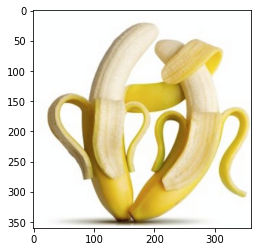

In [83]:
imshow(images[1])

In [84]:
real_labels = []
for i in range(len(dataset)):
  real_labels.append(dataset[i][1])

####Предсказание

In [85]:
predictions=[]
for i in images:
  predictions.append(predict_top(model.cuda(), i))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [86]:
pred = []
for i in predictions:
  pred.append(i[1])

In [87]:
real = []
for i in real_labels:
  real.append(i['boxes'])

In [88]:
real

[tensor([[ 88,  41, 415, 393]]), tensor([[162,  50, 310, 354],
         [ 81,  16, 220, 348]]), tensor([[162,  50, 310, 354],
         [ 81,  16, 220, 348]]), tensor([[112, 144, 173, 211],
         [250, 140, 322, 215]]), tensor([[112, 144, 173, 211],
         [250, 140, 322, 215]]), tensor([[ 25, 135, 663, 543],
         [ 86,  92, 736, 385]]), tensor([[ 25, 135, 663, 543],
         [ 86,  92, 736, 385]]), tensor([[  58,  124, 1776, 1910]]), tensor([[ 63,  17, 560, 323]]), tensor([[ 17, 195, 202, 356],
         [200, 207, 376, 365],
         [223,  52, 389, 217],
         [261, 157, 412, 264]]), tensor([[ 17, 195, 202, 356],
         [200, 207, 376, 365],
         [223,  52, 389, 217],
         [261, 157, 412, 264]]), tensor([[ 17, 195, 202, 356],
         [200, 207, 376, 365],
         [223,  52, 389, 217],
         [261, 157, 412, 264]]), tensor([[ 17, 195, 202, 356],
         [200, 207, 376, 365],
         [223,  52, 389, 217],
         [261, 157, 412, 264]]), tensor([[ 219,  494, 

In [89]:
pred

[tensor([[ 90.2081,  37.6826, 405.8257, 385.6310]]),
 tensor([[156.5515,  85.2253, 327.9322, 354.4667],
         [ 86.0758,  10.7772, 215.5045, 353.2645]]),
 tensor([[156.5515,  85.2253, 327.9322, 354.4667],
         [ 86.0758,  10.7772, 215.5045, 353.2645]]),
 tensor([[328.4182, 141.6831, 397.1883, 212.7910],
         [249.0203, 137.3174, 321.5786, 211.1099],
         [104.3261, 138.0487, 173.1718, 209.9395]]),
 tensor([[328.4182, 141.6831, 397.1883, 212.7910],
         [249.0203, 137.3174, 321.5786, 211.1099],
         [104.3261, 138.0487, 173.1718, 209.9395]]),
 tensor([[119.4124, 134.0719, 714.6900, 419.5822],
         [ 32.5113, 207.4390, 676.5330, 535.1169]]),
 tensor([[119.4124, 134.0719, 714.6900, 419.5822],
         [ 32.5113, 207.4390, 676.5330, 535.1169]]),
 tensor([[  97.7860,   62.8402, 1694.2366, 1967.5889]]),
 tensor([[ 78.3132,  55.7540, 565.4686, 329.6683]]),
 tensor([[193.0181, 208.1254, 376.1647, 383.1815],
         [  4.5019, 198.2782, 202.8363, 370.3976],
         

In [90]:
pred_labels=[]
for i in predictions:
  pred_labels.append(i[0])

In [91]:
pred_labels

[['apple'],
 ['banana', 'banana'],
 ['banana', 'banana'],
 ['apple', 'apple', 'apple'],
 ['apple', 'apple', 'apple'],
 ['banana', 'banana'],
 ['banana', 'banana'],
 ['apple'],
 ['banana'],
 ['orange', 'orange', 'orange', 'orange'],
 ['orange', 'orange', 'orange', 'orange'],
 ['orange', 'orange', 'orange', 'orange'],
 ['orange', 'orange', 'orange', 'orange'],
 ['apple', 'apple', 'apple', 'apple'],
 ['apple', 'apple', 'apple', 'apple'],
 ['apple', 'apple', 'apple', 'apple'],
 ['apple', 'apple', 'apple', 'apple'],
 ['banana', 'apple'],
 ['banana', 'apple'],
 ['banana', 'apple'],
 ['banana', 'orange', 'apple', 'banana'],
 ['banana', 'orange', 'apple', 'banana'],
 ['banana', 'orange', 'apple', 'banana'],
 ['banana', 'orange', 'apple', 'banana'],
 ['banana', 'orange', 'apple', 'banana'],
 ['banana', 'banana', 'banana', 'banana', 'banana', 'banana'],
 ['banana', 'banana', 'banana', 'banana', 'banana', 'banana'],
 ['banana', 'banana', 'banana', 'banana', 'banana', 'banana'],
 ['banana', 'banan

In [92]:
real_lab = []
for i in real_labels:
  real_lab.append(i['labels'])
  

In [93]:
real_lab

[['apple'],
 ['banana', 'banana'],
 ['banana', 'banana'],
 ['apple', 'apple'],
 ['apple', 'apple'],
 ['banana', 'banana'],
 ['banana', 'banana'],
 ['apple'],
 ['banana'],
 ['orange', 'orange', 'orange', 'orange'],
 ['orange', 'orange', 'orange', 'orange'],
 ['orange', 'orange', 'orange', 'orange'],
 ['orange', 'orange', 'orange', 'orange'],
 ['apple', 'apple', 'apple', 'apple'],
 ['apple', 'apple', 'apple', 'apple'],
 ['apple', 'apple', 'apple', 'apple'],
 ['apple', 'apple', 'apple', 'apple'],
 ['banana', 'apple', 'orange'],
 ['banana', 'apple', 'orange'],
 ['banana', 'apple', 'orange'],
 ['orange', 'apple', 'banana', 'banana', 'banana'],
 ['orange', 'apple', 'banana', 'banana', 'banana'],
 ['orange', 'apple', 'banana', 'banana', 'banana'],
 ['orange', 'apple', 'banana', 'banana', 'banana'],
 ['orange', 'apple', 'banana', 'banana', 'banana'],
 ['banana', 'banana', 'banana', 'banana'],
 ['banana', 'banana', 'banana', 'banana'],
 ['banana', 'banana', 'banana', 'banana'],
 ['banana', 'ban

Посчитаем количество реальных и предсказанных меток каждого класса

In [94]:
real_oranges = 0
real_apples=0
real_bananas=0
for i in real_lab:
  for j in i:
    if j=='orange':
      real_oranges+=1
    elif j=='apple':
      real_apples+=1
    elif j=='banana':
      real_bananas+=1
print('real_oranges', real_oranges)
print('real_apples',real_apples)
print('real_bananas', real_bananas)

pred_oranges = 0
pred_apples=0
pred_bananas=0
for i in pred_labels:
  for j in i:
    if j=='orange':
      pred_oranges+=1
    elif j=='apple':
      pred_apples+=1
    elif j=='banana':
      pred_bananas+=1
print()
print('pred_oranges', pred_oranges)
print('pred_apples',pred_apples)
print('pred_bananas', pred_bananas)

real_oranges 126
real_apples 92
real_bananas 105

pred_oranges 115
pred_apples 88
pred_bananas 105


In [95]:
predictions

[(['apple'],
  tensor([[ 90.2081,  37.6826, 405.8257, 385.6310]]),
  tensor([0.9500])),
 (['banana', 'banana'], tensor([[156.5515,  85.2253, 327.9322, 354.4667],
          [ 86.0758,  10.7772, 215.5045, 353.2645]]), tensor([0.8505, 0.8288])),
 (['banana', 'banana'], tensor([[156.5515,  85.2253, 327.9322, 354.4667],
          [ 86.0758,  10.7772, 215.5045, 353.2645]]), tensor([0.8505, 0.8288])),
 (['apple', 'apple', 'apple'],
  tensor([[328.4182, 141.6831, 397.1883, 212.7910],
          [249.0203, 137.3174, 321.5786, 211.1099],
          [104.3261, 138.0487, 173.1718, 209.9395]]),
  tensor([0.9290, 0.9261, 0.8866])),
 (['apple', 'apple', 'apple'],
  tensor([[328.4182, 141.6831, 397.1883, 212.7910],
          [249.0203, 137.3174, 321.5786, 211.1099],
          [104.3261, 138.0487, 173.1718, 209.9395]]),
  tensor([0.9290, 0.9261, 0.8866])),
 (['banana', 'banana'], tensor([[119.4124, 134.0719, 714.6900, 419.5822],
          [ 32.5113, 207.4390, 676.5330, 535.1169]]), tensor([0.9923, 0.9158

In [96]:
pred_box_label = []
for i in range(len(predictions)):
  d={}
  d['labels'] = predictions[i][0]
  d['boxes']=predictions[i][1]
  pred_box_label.append(d)

In [97]:
pred_box_label

[{'boxes': tensor([[ 90.2081,  37.6826, 405.8257, 385.6310]]),
  'labels': ['apple']},
 {'boxes': tensor([[156.5515,  85.2253, 327.9322, 354.4667],
          [ 86.0758,  10.7772, 215.5045, 353.2645]]),
  'labels': ['banana', 'banana']},
 {'boxes': tensor([[156.5515,  85.2253, 327.9322, 354.4667],
          [ 86.0758,  10.7772, 215.5045, 353.2645]]),
  'labels': ['banana', 'banana']},
 {'boxes': tensor([[328.4182, 141.6831, 397.1883, 212.7910],
          [249.0203, 137.3174, 321.5786, 211.1099],
          [104.3261, 138.0487, 173.1718, 209.9395]]),
  'labels': ['apple', 'apple', 'apple']},
 {'boxes': tensor([[328.4182, 141.6831, 397.1883, 212.7910],
          [249.0203, 137.3174, 321.5786, 211.1099],
          [104.3261, 138.0487, 173.1718, 209.9395]]),
  'labels': ['apple', 'apple', 'apple']},
 {'boxes': tensor([[119.4124, 134.0719, 714.6900, 419.5822],
          [ 32.5113, 207.4390, 676.5330, 535.1169]]),
  'labels': ['banana', 'banana']},
 {'boxes': tensor([[119.4124, 134.0719, 714.6

####Функция для подсчета площади пересечения 

In [98]:
def calc_iou(gt_bbox, pred_bbox):
  
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #если не пересекаются, то 0
    if(x_bottomright_gt< x_topleft_p):
      return 0.0
    if(y_bottomright_gt< y_topleft_p):
      return 0.0
    if(x_topleft_gt> x_bottomright_p):
      return 0.0
    if(y_topleft_gt> y_bottomright_p):
      return 0.0
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

Нарисуем одну картинку и предсказания к ней

['banana']
tensor([[ 78.3132,  55.7540, 565.4686, 329.6683]])
tensor([0.9685])


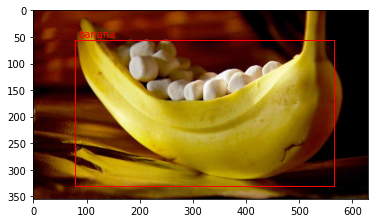

In [99]:
#картинка
image = images[8]

#предсказания
labels, boxes, scores = predictions[8]

print(labels) 
print(boxes)
print(scores)
show_labeled_image(image, boxes, labels)

А теперь нарисуем ту же картинку и реальные метки

In [100]:
boxes = real_labels[8]['boxes']
labels = real_labels[8]['labels']

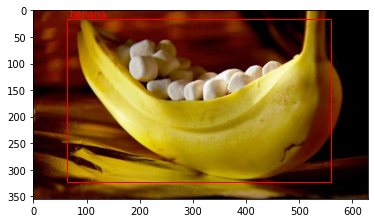

In [101]:
show_labeled_image(image, boxes, labels)

['apple', 'apple', 'apple', 'apple']
tensor([[ 215.7618,  525.2927,  920.7198, 1183.6082],
        [  25.7788,  330.2414,  632.5491,  872.6776],
        [1297.9214,  325.1129, 1865.0071,  894.3726],
        [ 965.4141,  584.1546, 1657.4417, 1166.5096]])
tensor([0.9726, 0.9535, 0.8856, 0.8610])

ПРЕДСКАЗАНИЕ


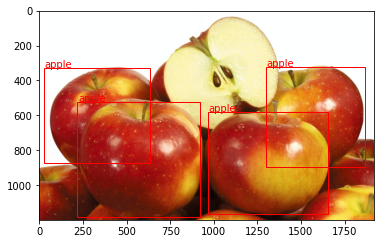

In [102]:
image = images[15]

#предсказания
labels, boxes, scores = predictions[15]

print(labels) 
print(boxes)
print(scores)
print()
print('ПРЕДСКАЗАНИЕ')
show_labeled_image(image, boxes, labels)

ПРИМЕР


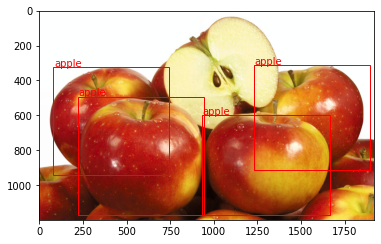

In [103]:
boxes = real_labels[15]['boxes']
labels = real_labels[15]['labels']
print('ПРИМЕР')
show_labeled_image(image, boxes, labels)

####Функция для вывода результатов (true positive, false positive, false negative)

Функция ниже выводит четыре словаря. Первый - это общее количество правильно предсказанных меток, ошибок первого рода и ошибок второго рода на одной картинке без учета классов. Еще три словаря соответствуют каждому классу - в каждом классе выводятся true positive, false positive и false negative.

In [104]:
def get_single_image_results(h,real_lab, pred_box_label, iou_thr):
    r_labels=[] #правильные метки
    p_labels=[] #предсказанные метки
    ious=[] #пересечения
    
    for i in range(len(pred_box_label[h]['boxes'])):
        j=0
        while j<len(real_labels[h]['boxes']):
            iou= calc_iou(pred_box_label[h]['boxes'][i], real_labels[h]['boxes'][j])
            if iou >iou_thr:
                ious.append(iou)
                p_labels.append(pred_box_label[h]['labels'][i])
                r_labels.append(real_labels[h]['labels'][j])
                break 
            j+=1
    iou_sort = np.argsort(ious)[::1]
    gt_match_idx=[]
    pred_match_idx=[] #правильно предсказанные метки
    for idx in range(len(ious)):
      gt_idx=r_labels[idx]
      r_idx= p_labels[idx]
      if gt_idx==r_idx:
        gt_match_idx.append(gt_idx)
  
    tp_apples = gt_match_idx.count('apple')
    tp_oranges= gt_match_idx.count('orange')
    tp_bananas= gt_match_idx.count('banana')

    fp_oranges = pred_box_label[h]['labels'].count('orange') - gt_match_idx.count('orange')
    fp_apples = pred_box_label[h]['labels'].count('apple') - gt_match_idx.count('apple')
    fp_bananas = pred_box_label[h]['labels'].count('banana') - gt_match_idx.count('banana')

    fn_bananas = real_labels[h]['labels'].count('banana') - gt_match_idx.count('banana')
    if fn_bananas<0:
      fp_bananas += abs(fn_bananas)
      fn_bananas = 0
    fn_apples = real_labels[h]['labels'].count('apple') - gt_match_idx.count('apple')
    if fn_apples<0:
      fp_apples += abs(fn_apples)
      fn_apples = 0
    fn_oranges =real_labels[h]['labels'].count('orange') - gt_match_idx.count('orange')
    if fn_oranges<0:
      fp_oranges += abs(fn_oranges)
      fn_oranges = 0
    tp= len(gt_match_idx)
    fp= len(pred_box_label[h]['boxes']) - len(gt_match_idx)
    fn = len(real_labels[h]['boxes']) - len(gt_match_idx)
    if fn<0:
      fp = abs(fn)
      fn=0
    if fp<0:
      fn = abs(fp)
      fp=0
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}, {'tp_oranges':tp_oranges,
                                                                               'fp_oranges':fp_oranges,
                                                                               'fn_oranges':fn_oranges}, {'tp_apples':tp_apples,
                                                                                                          'fp_apples':fp_apples,
                                                                                                          'fn_apples':fn_apples}, {'tp_bananas':tp_bananas,
                                                                                                                                   'fp_bananas':fp_bananas,
                                                                                                                                   'fn_bananas':fn_bananas}

Пример вывода функции

['apple']
tensor([[ 90.2081,  37.6826, 405.8257, 385.6310]])
tensor([0.9500])

ПРЕДСКАЗАНИЕ


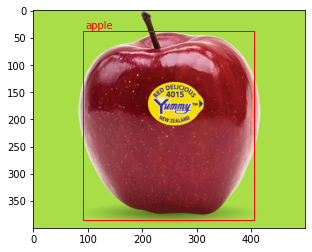

In [106]:
image = images[0]

#предсказания
labels, boxes, scores = predictions[0]

print(labels) 
print(boxes)
print(scores)
print()
print('ПРЕДСКАЗАНИЕ')
show_labeled_image(image, boxes, labels)

In [105]:
get_single_image_results(0,images, pred_box_label, 0.6)

({'false_negative': 0, 'false_positive': 0, 'true_positive': 1},
 {'fn_oranges': 0, 'fp_oranges': 0, 'tp_oranges': 0},
 {'fn_apples': 0, 'fp_apples': 0, 'tp_apples': 1},
 {'fn_bananas': 0, 'fp_bananas': 0, 'tp_bananas': 0})

####Функция для расчета presicion и recall

Функция ниже считает precision и recall для каждой картинки отдельно. На вход поступает словарь.

In [107]:
def calc_precision_recall(image_results):
  
    true_positive=image_results[list(image_results.keys())[0]]
    false_positive=image_results[list(image_results.keys())[1]]
    false_negative=image_results[list(image_results.keys())[2]]
    try:
      precision = true_positive/(true_positive+ false_positive)
    except ZeroDivisionError:
      precision=0.0
    try:
      recall = true_positive/(true_positive + false_negative)
    except ZeroDivisionError:
      recall=0.0

    return (precision, recall)

####Результаты для каждой картинки

In [108]:
result = pd.DataFrame()
result['image']  = np.arange(len(dataset))
tr_pos = []
fal_neg = []
fal_pos = []
pr = []
rec = []
for i in range(len(dataset)):
  image_results = get_single_image_results(i, real_labels, pred_box_label, 0.4)
  tr_pos.append(image_results[0]['true_positive'])
  fal_neg.append(image_results[0]['false_negative'])
  fal_pos.append(image_results[0]['false_positive'])
  s = calc_precision_recall(image_results[0])
  pr.append(s[0])
  rec.append(s[1])

In [109]:
result['real_labels'] = real_lab
result['pred_labels'] = pred_labels
result['true_positive'] = tr_pos
result['false_negative'] = fal_neg
result['false_positive'] = fal_pos
result['precision'] = pr
result['recall'] = rec

Для каждой картинки

In [110]:
result

,image,real_labels,pred_labels,true_positive,false_negative,false_positive,precision,recall
0,0,[apple],[apple],1,0,0,1.000000,1.000000
1,1,"[banana, banana]","[banana, banana]",2,0,0,1.000000,1.000000
2,2,"[banana, banana]","[banana, banana]",2,0,0,1.000000,1.000000
3,3,"[apple, apple]","[apple, apple, apple]",2,0,1,0.666667,1.000000
4,4,"[apple, apple]","[apple, apple, apple]",2,0,1,0.666667,1.000000
...,...,...,...,...,...,...,...,...
112,112,[banana],[banana],1,0,0,1.000000,1.000000
113,113,"[orange, banana, apple]","[apple, orange]",2,1,0,1.000000,0.666667
114,114,"[orange, banana, apple]","[apple, orange]",2,1,0,1.000000,0.666667
115,115,"[orange, banana, apple]","[apple, orange]",2,1,0,1.000000,0.666667


####Общее качество, та самая функция

Функция ниже считает precision и recall для каждого класса по всей тестовой выборке. На вход функции в качестве аргументов подаются веса модели и датасет.

In [111]:
def metrics(dataset, model):
  #на вход поступает датасет с картинками и реальными метками (боксы, подписи)
  images = []
  for i in range(len(dataset)):
    images.append(dataset[i][0])
  real_labels = []
  for i in range(len(dataset)):
    real_labels.append(dataset[i][1])
  predictions=[]
  #на вход поступают веса модели
  #детектируем
  for i in images:
    predictions.append(predict_top(model.cuda(), i))
  pred_box_label = []
  for i in range(len(predictions)):
    d={}
    d['labels'] = predictions[i][0]
    d['boxes']=predictions[i][1]
    pred_box_label.append(d)
  tp_apples = 0
  tp_bananas = 0
  tp_oranges = 0
  fp_apples = 0
  fp_bananas = 0
  fp_oranges = 0
  fn_apples = 0
  fn_bananas = 0
  fn_oranges = 0
  for i in range(len(real_labels)):
    image_results_oranges = get_single_image_results(i, real_labels, pred_box_label, 0.5)[1]
    tp_oranges+=image_results_oranges['tp_oranges']
    fn_oranges+=image_results_oranges['fn_oranges']
    fp_oranges+=image_results_oranges['fp_oranges']
    
    image_results_apples = get_single_image_results(i, real_labels, pred_box_label, 0.5)[2]
    tp_apples+=image_results_apples['tp_apples']
    fn_apples+=image_results_apples['fn_apples']
    fp_apples+=image_results_apples['fp_apples']
    
    image_results_bananas = get_single_image_results(i, real_labels, pred_box_label, 0.5)[3]
    tp_bananas+=image_results_bananas['tp_bananas']
    fn_bananas+=image_results_bananas['fn_bananas']
    fp_bananas+=image_results_bananas['fp_bananas']
    
  precision_bananas = tp_bananas/(tp_bananas+ fp_bananas)
  precision_oranges = tp_oranges/(tp_oranges+ fp_oranges)
  precision_apples = tp_apples/(tp_apples+ fp_apples)

  recall_bananas = tp_bananas/(tp_bananas+ fn_bananas)
  recall_oranges = tp_oranges/(tp_oranges+ fn_oranges)
  recall_apples = tp_apples/(tp_apples+ fn_apples)
  return {'precision_bananas':precision_bananas, 'precision_oranges':precision_oranges,
          'precision_apples':precision_apples, 'recall_bananas':recall_bananas,
          'recall_oranges':recall_oranges, 'recall_apples':recall_apples}

In [112]:
metrics(dataset, model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


{'precision_apples': 0.9545454545454546,
 'precision_bananas': 0.8317757009345794,
 'precision_oranges': 0.8695652173913043,
 'recall_apples': 0.9130434782608695,
 'recall_bananas': 0.8317757009345794,
 'recall_oranges': 0.7936507936507936}

###Пункт 7. Зачем всё это нужно?

Будущее за нейросетями - это чувствуется в воде, земле и воздухе. Нет, это не грубоватая отсылка к "Властелину Колец", а суровая правда - подводные лодки, автомобили, ракеты, самолеты переходят (или уже перешли) на автоматическое управление. Внедрение автоматических пилотов осуществляется путем сложного сочетания различных методов машинного обучения, в том числе и детекции с сегментацией. В данном ноутбуке представлена сегментация фруктов, а не разметки или пешеходов, это не поможет в создании автопилотов, но может быть полезно для решения других задач, требующих автоматизации. Например, почему бы не создать нейро-повара? На вход он будет получать фотографии имеющихся в доме продуктов и генерировать из них рецепты, а в последствии и готовить сам. Но чтобы что-то приготовить, надо знать, что в наличии, в этом-то и поможет задача детекции продуктов, в частности, фруктов.

Во все времена люди стремились быть красивее. В борьбе за долголетие и тонкую талию побеждают те, кто умело и профессионально сочетают правильное питание и спорт. Правильное питание - понятие растяжимое, и познается оно разными способами: кто-то читает блоги моделей, кто-то нанимает диетолога, кто-то просто голодает. Диета будущего - это приложение, в которое вводятся индивидуальные характеристики здоровья человека (уровень сахара и т.д.), физические параметры. Это приложение принимает на вход фотографии еды и выдает калорийность и  метку, можно или нельзя это есть конкретному человеку. Для этого датасет надо дополнить картинками еды и обучать дольше.

С каждым годом техника становится всё "умнее". СМАРТ стиральные машины, СМАРТ телефоны, СМАРТ часы... Холодильники тоже на месте не стоят. Сейчас уже есть такие, что контролируют температуру и сами себя размораживают. Можно пойти еще дальше и научить холодильник подбирать для каждых продуктов свою температуру. Реализовать это сложно, ведь многим людям свойственно все без разбора смахивать в холодильник, не раскладывая по полкам, соответственно, рядом могут оказаться яблоки, молоко, мясо и мотыль для рыбалки. Надо придумать такую физическую форму холодильника, в котором можно реализовать механизм хранения разных продуктов при разной температуре (возможно, он будет как-то сам переставлять полки или что-то в этом роде).

Ну и последнее, что я в состоянии сгенерировать, это утилизация испорченных фруктов. Поскольку модель обучалась на свежих и красивых фруктах, то она может просто не распознать испортившиеся, и отправить их в мусорное ведро. Чтобы это реализовать, можно встроить модель в тот же самый холодильник, а к низу холодильника приделать ведро.


